### Подготовим данные.

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

sns.set_theme()
pd.set_option('display.float_format', lambda x: '%.5f' % x) # для удобного отображения describe

In [2]:
trips19 = pd.read_csv('tripdata_2019-05.csv')

In [3]:
trips20 = pd.read_csv('tripdata_2020-05.csv')

/home/khodor/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# для того, чтобы не засорять оперативу непонятными данными, удалим их на время
del_columns = ['VendorID', 'RatecodeID', 'store_and_fwd_flag', 'extra', 'mta_tax', 'tip_amount', 'improvement_surcharge', 'congestion_surcharge']
trips19 = trips19.drop(columns=del_columns)
trips20 = trips20.drop(columns=del_columns)

Посмотрим, какие пропущенные значения есть в данных.

In [5]:
for el in trips19.columns:
    print(el, trips19[el].isna().sum())

tpep_pickup_datetime 0
tpep_dropoff_datetime 0
passenger_count 0
trip_distance 0
PULocationID 0
DOLocationID 0
payment_type 0
fare_amount 0
tolls_amount 0
total_amount 0


In [6]:
for el in trips20.columns:
    print(el, trips20[el].isna().sum())

tpep_pickup_datetime 0
tpep_dropoff_datetime 0
passenger_count 58891
trip_distance 0
PULocationID 0
DOLocationID 0
payment_type 58891
fare_amount 0
tolls_amount 0
total_amount 0


На данный момент из пропущенных данных для нас интерес может представлять только колонка о количестве пассажиров.

Посмотрим на самое частое значение и заменим на него все пропущенные значения.

In [7]:
max_passengers_count = trips20['passenger_count'].value_counts().idxmax()
print("Max passengers count = ", max_passengers_count)
trips20.passenger_count = trips20.passenger_count.fillna(max_passengers_count)

Max passengers count =  1.0


Посмотрим на количество колонок, в которых встречаются данные со значением Nan.

Преобразуем формат ячеек с временем для удобства.

In [8]:
trips19['tpep_pickup_datetime'] = pd.to_datetime(trips19.tpep_pickup_datetime)
trips19['tpep_dropoff_datetime'] = pd.to_datetime(trips19.tpep_dropoff_datetime)

In [9]:
trips20['tpep_pickup_datetime'] = pd.to_datetime(trips20.tpep_pickup_datetime)
trips20['tpep_dropoff_datetime'] = pd.to_datetime(trips20.tpep_dropoff_datetime)

Удалим данные, в которых начало во времени находится после конца, а также те строки, в которых id районов посадки/высадки больше 263(их именно столько).

In [10]:
trips19 = trips19[trips19.tpep_pickup_datetime <= trips19.tpep_dropoff_datetime]
trips19 = trips19[trips19.PULocationID <= 263]
trips19 = trips19[trips19.DOLocationID <= 263]

In [11]:
trips20 = trips20[trips20.tpep_pickup_datetime <= trips20.tpep_dropoff_datetime]
trips20 = trips20[trips20.PULocationID <= 263]
trips20 = trips20[trips20.DOLocationID <= 263]

Введём новые колонки: 

1. с датой начала поездки; 

2. с часом начала и конца;

3. с днём недели начала поездки; 

4. с временем продолжительности поездки(день конца поездки игнорируем, т.к. почти все поездки будут в промежутке одного дня);

5. временем поездки в секундах;

6. средней скоростью в м/с.

In [12]:
MILES_TO_KM = 1609.34

In [13]:
trips19['trip_pickup_day'] = trips19.tpep_pickup_datetime.dt.day
trips19['week_day'] = trips19.tpep_pickup_datetime.dt.dayofweek
trips19['trip_pickup_hour'] = trips19.tpep_pickup_datetime.dt.hour
trips19['trip_dropoff_hour'] = trips19.tpep_dropoff_datetime.dt.hour
trips19['trip_duration'] = trips19.tpep_dropoff_datetime - trips19.tpep_pickup_datetime
trips19['trip_duration_secs'] = trips19.trip_duration.dt.seconds
trips19['trip_distance'] = trips19['trip_distance'] * MILES_TO_KM
trips19['average_velocity'] = trips19['trip_distance'] / trips19['trip_duration_secs']

In [14]:
trips20['trip_pickup_day'] = trips20.tpep_pickup_datetime.dt.day
trips20['week_day'] = trips20.tpep_pickup_datetime.dt.dayofweek
trips20['trip_pickup_hour'] = trips20.tpep_pickup_datetime.dt.hour
trips20['trip_dropoff_hour'] = trips20.tpep_dropoff_datetime.dt.hour
trips20['trip_duration'] = trips20.tpep_dropoff_datetime - trips20.tpep_pickup_datetime
trips20['trip_duration_secs'] = trips20.trip_duration.dt.seconds
trips20['trip_distance'] = trips20['trip_distance'] * MILES_TO_KM
trips20['average_velocity'] = trips20['trip_distance'] / trips20['trip_duration_secs']

Посмотрим, есть ли в данных нереальные случаи.

Установим ограничение для средней скорости в 50 м/с сверху и 0.1 м/с снизу, а также удалим строки, в которых преодолено нулевое расстояние за ненулевое время, при этом получена некоторая сумма за поездку.

Так же удалим строки с отрицательной стоимостью поездки.

In [15]:
trips19 = trips19[trips19.average_velocity <= 50]
trips19 = trips19[trips19.average_velocity >= 1]
trips19 = trips19.drop(trips19[(trips19.trip_distance == 0) & (trips19.total_amount > 0) & (trips19.trip_duration_secs > 0)].index)
trips19 = trips19[trips19.total_amount >= 0]

In [16]:
trips20 = trips20[trips20.average_velocity <= 50]
trips20 = trips20[trips20.average_velocity >= 1]
trips20 = trips20.drop(trips20[(trips20.trip_distance == 0) & (trips20.total_amount > 0) & (trips20.trip_duration_secs > 0)].index)
trips20 = trips20[trips20.total_amount >= 0]

В последний понедельник мая проводится федеральный праздник День Памяти, который является государственным выходным. Установим для дат 27.05.19 и 25.05.20 значение 1 в новой колонке, 0 всем остальным.

In [17]:
trips19['is_holiday'] = [x.date().day == 27 for x in trips19['tpep_pickup_datetime']]
trips20['is_holiday'] = [x.date().day == 25 for x in trips20['tpep_pickup_datetime']]

Посмотрим на некоторые статистики, которые может предоставить python.

In [18]:
trips19.describe()

,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,tolls_amount,total_amount,trip_pickup_day,week_day,trip_pickup_hour,trip_dropoff_hour,trip_duration,trip_duration_secs,average_velocity
count,7364716.00000,7364716.00000,7364716.00000,7364716.00000,7364716.00000,7364716.00000,7364716.00000,7364716.00000,7364716.00000,7364716.00000,7364716.00000,7364716.00000,7364716,7364716.00000,7364716.00000
mean,1.57073,4874.99326,162.62866,160.67312,1.28016,13.21127,0.38756,19.30304,15.47498,2.99063,13.97352,14.02037,0 days 00:14:59.785428,899.77370,5.00294
std,1.22100,6172.85277,65.80984,69.81093,0.46400,11.15897,1.67767,13.93455,8.93429,1.84347,5.99823,6.08811,0 days 00:12:26.548646,745.53358,2.71642
min,0.00000,16.09340,1.00000,1.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0 days 00:00:01,1.00000,1.00005
25%,1.00000,1609.34000,114.00000,107.00000,1.00000,6.50000,0.00000,11.30000,8.00000,2.00000,10.00000,10.00000,0 days 00:06:54,414.00000,3.21868
50%,1.00000,2703.69120,162.00000,162.00000,1.00000,9.50000,0.00000,14.80000,15.00000,3.00000,15.00000,15.00000,0 days 00:11:31,691.00000,4.36643
75%,2.00000,4988.95400,233.00000,233.00000,2.00000,15.00000,0.00000,20.80000,23.00000,4.00000,19.00000,19.00000,0 days 00:18:56,1136.00000,5.98515
max,9.00000,319196.49560,263.00000,263.00000,4.00000,4016.50000,706.68000,4020.30000,31.00000,6.00000,23.00000,23.00000,1 days 06:10:50,51841.00000,49.97424


In [19]:
trips20.describe()

,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,tolls_amount,total_amount,trip_pickup_day,week_day,trip_pickup_hour,trip_dropoff_hour,trip_duration,trip_duration_secs,average_velocity
count,330471.00000,330471.00000,330471.00000,330471.00000,274825.00000,330471.00000,330471.00000,330471.00000,330471.00000,330471.00000,330471.00000,330471.00000,330471,330471.00000,330471.00000
mean,1.26830,5997.37083,152.11257,147.27823,1.41196,13.34287,0.39342,18.14100,16.38488,3.00259,13.10049,13.15487,0 days 00:11:47.171597,707.17160,7.45323
std,0.91647,7241.93656,70.28768,74.10171,0.53022,12.05296,1.74630,13.44482,8.83033,1.87694,5.30301,5.33937,0 days 00:09:58.915852,598.91585,3.34638
min,0.00000,16.09340,1.00000,1.00000,1.00000,-10.86000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0 days 00:00:02,2.00000,1.00236
25%,1.00000,1770.27400,90.00000,75.00000,1.00000,6.00000,0.00000,10.30000,9.00000,1.00000,9.00000,9.00000,0 days 00:05:14,314.00000,5.16873
50%,1.00000,3283.05360,142.00000,143.00000,1.00000,9.00000,0.00000,13.80000,16.00000,3.00000,14.00000,14.00000,0 days 00:08:55,535.00000,6.63645
75%,1.00000,6920.16200,230.00000,230.00000,2.00000,15.50000,0.00000,20.76000,24.00000,4.00000,17.00000,17.00000,0 days 00:15:13,913.00000,8.83707
max,6.00000,491009.63400,263.00000,263.00000,4.00000,801.50000,200.00000,1042.82000,31.00000,6.00000,23.00000,23.00000,0 days 11:56:00,42960.00000,49.97082


Из describe можем сделать несколько выводов:
0. Среднее количество пассажиров снизилось с 1.57 до 1.27 из-за социального дистанцирования. Также максимальное количество уменьшилось от 9 до 6 человек(среди жёлтых такси так же есть минивены, потому такое большое количество неудивительно).
1. Средняя дистанция в 20м году выросла с 5км до 6км. Можем сделать вывод, что люди стали чаще пользоваться такси для каких-то длительных поездок, ведь если расстояние небольшое, может быть рентабельнее просто пойти пешком, чтобы ни с кем зря не контактировать.
2. Несмотря на увеличение дистанции средняя продолжительность поездки уменьшилось(соответственно выросла средняя скорость) из-за меньшей загруженности дорог.


### Получим представление о районах Нью-Йорка.

В Нью-Йорке есть 5 основных районов: Manhattan, Queens, Brooklyn, Staten Island и Bronx.

![ny_map](pictures/ny_map.jpg)

Manhattan является главным туристическим местом, а также скоплением главных бизнес-центров Нью-Йорка. Тут очень развита инфраструктура  (не)активного времяпрепровождения.

Queens является одним из наиболее "спальных" районов города. Однако тут расположен Национальный аэропорт имени Джона Кеннеди - аэропорт с самым большим трафиком пассажирских и грузовых авиаперевозок в мире, что в купе с тем фактом, что тут происходит множество спортивных мероприятий, добавляет посещаемости приезжими.

Brooklyn - самый населённый район Нью-Йорка. При этом тут очень развита инфраструктура локальных мероприятий, что позволяет жителям не ездить куда-то, а "жить на месте".

В Bronx'е находится печально известный своей неблагополучностью квартал Camp Apache. Однако сейчас там всё спокойно. Более того, среди туристов имеют популярность несколько иностранных кварталов

Staten Island - самый тихий район с наименьшей численностью населения. Туристов сюда не тянет в силу того, что тут "почти не на что смотреть". Однако с его замечательной природой можно отдохнуть от суеты других районов.

### Визуализируем данные.

In [20]:
# зададим размер графиков
plt.rcParams['figure.dpi'] = 90

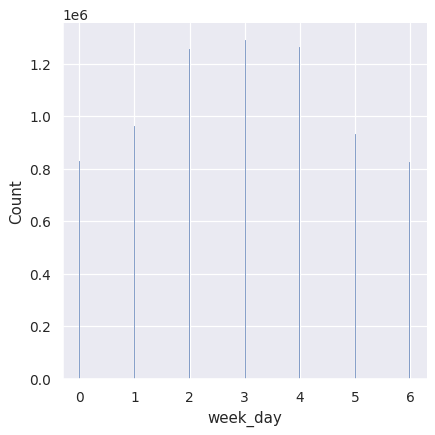

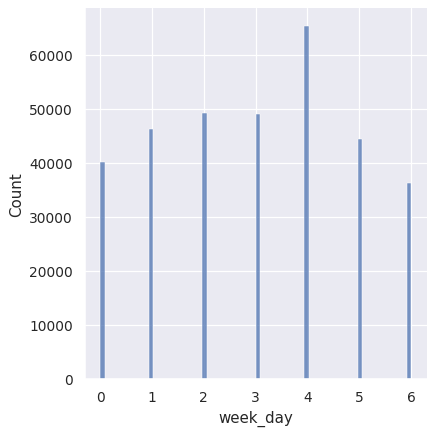

In [21]:
sns.displot(trips19, x='week_day')
sns.displot(trips20, x='week_day')

Выше видим выброс в пятницу в 2020м году. Возможно это объясняется режимом самоизоляции, который очень хочется нарушить в конце рабочей недели(либо в целом возвращение с работы домой, если это не является ежедневной рутиной).

В противоложность этому основная нагрузка в 19м году приходится на середину рабочей недели. # (хм, почему?)

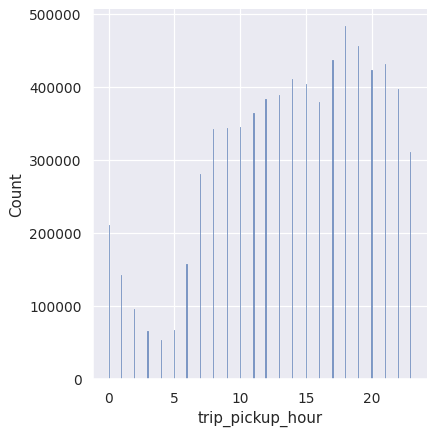

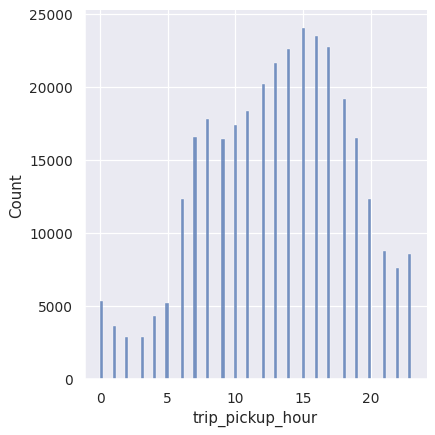

In [22]:
sns.displot(trips19.trip_pickup_hour)
sns.displot(trips20.trip_pickup_hour)

В 19 году видим основную нагрузку на 6-7 часов вечера, т.к. жители возвращаются с работы попутно заезжая по делам.

Однако в 20м году пик приходится на 3 часа дня. Возможно это потому что весь город подумал, что днём будет мало людей на улицах из-за работы и побежал делать свои дела.

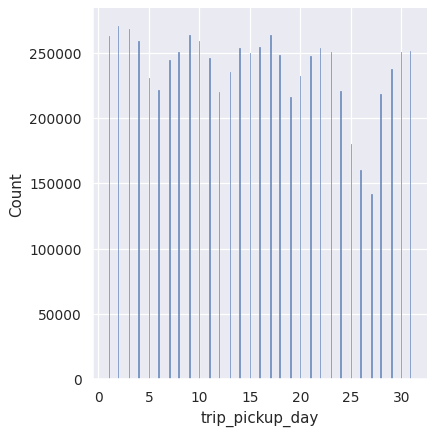

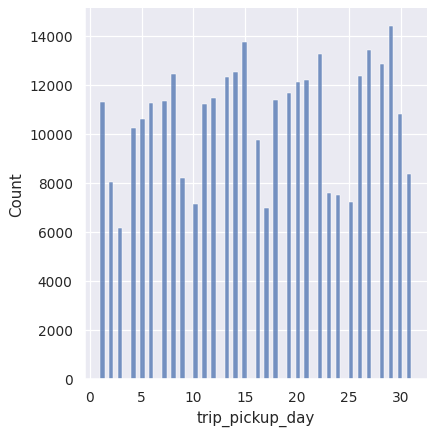

In [23]:
sns.displot(trips19, x='trip_pickup_day')
sns.displot(trips20, x='trip_pickup_day')

В оба года видим снижения использования средств передвижение во время выходных. Однако в 19м году имеется тенденция к постепенному снижению использования такси в течение рабочих дней(люди начинают готовится к отпуску и собственно отдыхать), тогда как в 20м году правило обратно: использование повышается, - тут это обуславливается тем, что люди уже устали сидеть некоторое время на карантине и начинают "подзабивать" на рекомендации самоизоляции.

Также отметим резкое(даже относительно выходных) снижение поездок 27.05.2019 и 25.05.2020, т.к. в этот день федеральный праздник День Памяти, являющийся выходным.

(0.0, 5000.0)

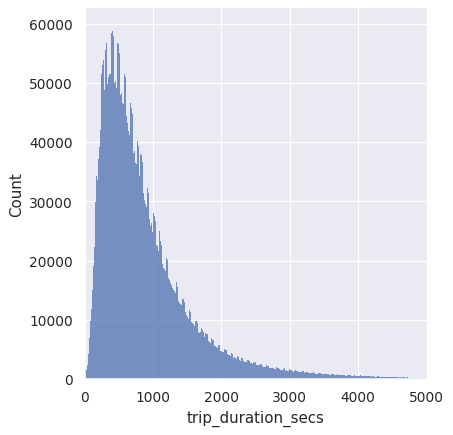

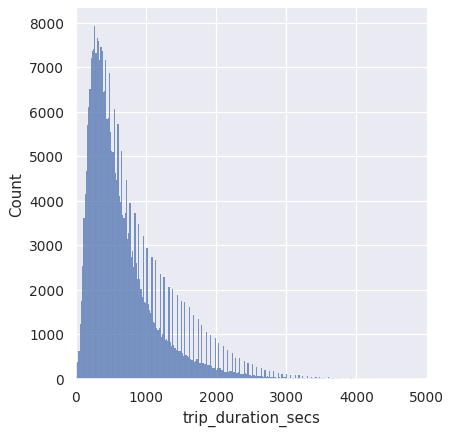

In [24]:
sns.displot(trips19, x='trip_duration_secs')
plt.xlim(0, 5000)
sns.displot(trips20, x='trip_duration_secs')
plt.xlim(0, 5000)

Похоже на распределение Пуассона или Максвелла.

На 2м графике существуют видимые выбросы, но это скорее из-за малого количества наблюдений. На 1м графике тенденция видна гораздо лучше и без выбросов.

Легко увидеть, что пользователи совершают очень много коротких поездок(до 30 минут) и очень мало длинных(более часа). На ум приходят две причины: немалая стоимость длинной поездки + средний пассажир(на мой взгляд) ездит ради скорости  и независимости от большинства других факторов(расписание общественного транспорта, движение от точки до точки).

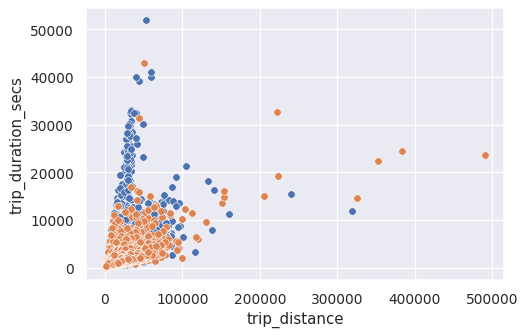

In [25]:
sns.scatterplot(data=trips19, x=trips19['trip_distance'], y=trips19['trip_duration_secs'])
sns.scatterplot(data=trips20, x=trips20['trip_distance'], y=trips20['trip_duration_secs'])

По графикам зависимости времени поездки от расстояния можем понять, что в целом они распределены примерно одинаково относительно друг друга(в целом этому виной например то, как мы убирали выбросы), т.е. эпидемия повлияла в данном случае только на количество поездок и уменьшение числа длительных поездок.

Однако есть очень много поездок с короткими дистанциями, но значительным временем. Это может объясняться большим трафиком в загруженные части дня. Как видим, систематически такой проблемы в 20м году не наблюдалось в силу того, что в целом загруженность узлов была меньше $\implies$ меньше пробок.

(0.0, 25.0)

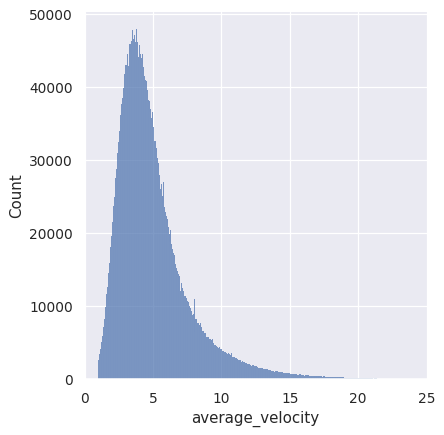

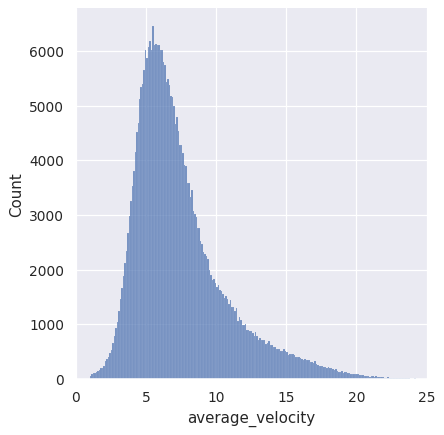

In [26]:
sns.displot(trips19, x='average_velocity')
plt.xlim(0, 25)
sns.displot(trips20, x='average_velocity')
plt.xlim(0, 25)

Видим уже знакомое распределение. Пики расположены около средних скоростей, которые составляют соответственно 18 и 27 км/ч, что вполне нормально для Нью-Йорка с его трафиком и пробками. Для передвижения со скоростью выше 48 км/ч(13.3 м/с) требуется либо быть каким-нибудь служебным автомобилем(скорая, полиция или пожарные), либо нарушать скоростной режим(чем, видимо, не пренебрегает некоторое количество водителей).

![19fool](pictures/19.jpg)
![20fool](pictures/20.jpg)

Кажется, за весь период мы ничего конкретного не вынесем. Особенно из прошлого года. Однако в этом году можно заметить, что популярным осталось направления Manhatten(и собственно весь он сам) и 2 аэропорта в Queens, а также в 19м году аэропорт Ньюарк. Однако можем заметить, что и так малое количество поездок из Staten Island стало ещё меньше(возможно потому что там много русских, а раз Президент сказал самоизолироваться, нужно самоизолироваться).

![19weekday](pictures/19weekday.jpg)
![19weekend](pictures/19weekend.jpg)

Здесь отображены поездки за рабочие дни и за выходные в мае 19ого года. 

На выходных видим значительное уменьшение поездок в район Staten Island. Это, возможно, обусловлено тем, что много жителей едут в другие районы на работу, а вся инфраструктура для отдыха на выходных присутствует на месте. Более того, вспоминая, что этот район является довольно тихим, можно сделать вывод, что жители не хотят суеты ещё и в выходные.

Также можно заметить небольшое уменьшение трафика из аэропортов на выходных(вероятно потому Нью-Йорк популярный город даже больше для рабочих визитов, чем для отдыха).

Однако в целом плотность в центральных районах не изменилась.

![20weelday](pictures/20weekday.jpg)
![20weekend](pictures/20weekend.jpg)

В противоположность этому на выходных 20ого видно значительное снижение использования такси. Популярным остались Manhattan и аэропорты, но очевидно снижение переездов между дальними частями города. Также можем заметить, что из аэропорта Ньюарк почти полностью перестали ездить.

В целом можно понять, что Manhattan всегда имел большой трафик из-за множества туристов и большого количества бизнес-центров.

### Начнём обучать модели

Удалим лишние фичи, которые не имеют нужный тип(### или как тут сказать).

In [27]:
drop_columns = ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'trip_duration']
trips19 = trips19.drop(columns=drop_columns)
trips20 = trips20.drop(columns=drop_columns)

Чётких правил по выбору размеров train- и test-выборок нет. Рекомендуется брать в каком-то из соотношений 90/10, 80/20, 70/30. По принципу Парето возьмём 80/20.

Гораздо большим значением обладает размер самой выборки. Проверим их.

In [28]:
print(trips19.shape, trips20.shape)

(7364716, 15) (330471, 15)


Имеем размеры в $7.3 \cdot 10^6$ и $3.3 \cdot 10^5$.
Это выборки с довольно большим и средним размером соответственно. Потому искусственно повышать размер train-выборки из-за недостаточности данных необходимости нет.

Чтобы не нагружать оперативную память пообучаем по очереди, но модели оставим.

In [29]:
train, test = train_test_split(trips19, test_size=0.2)

In [30]:
tr_ans = train['trip_duration_secs']
tr_ans = np.array(tr_ans.values.tolist()).astype(float)

train = train.drop(columns=['trip_duration_secs'])
train = np.array(train.values.tolist()).astype(float)

ts_ans = test['trip_duration_secs']
ts_ans = np.array(ts_ans.values.tolist()).astype(float)

test = test.drop(columns=['trip_duration_secs'])
test = np.array(test.values.tolist()).astype(float)

Для начала попробуем обучить линейную регрессию без параметров.

In [31]:
reg19_wp = LinearRegression().fit(train, tr_ans)

Посмотрим, как регрессия умеет предсказывать данные для train-выборки.

In [33]:
predicted = reg19_wp.predict(train)

Построим график отклонений предсказания от ответа:

(-2000.0, 2000.0)

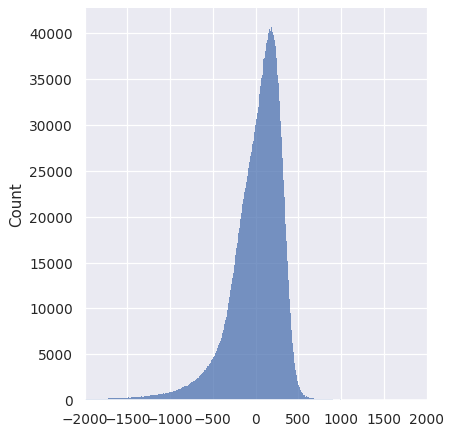

In [40]:
sns.displot(predicted - tr_ans)
plt.xlim(-2000, 2000)

In [42]:
np.mean(np.abs(predicted - tr_ans))

237.83028509841577

Среднее значение отклонение около 4х минут. Учитывая, что средняя поездка около 15 минут, это и правда много, однако для самоощущения 4 минуты - не такой большой промежуток. Но это же средняя ошибка. Из графика мы можем заметить, что есть очень большое отклонение в отрицательную сторону: пользователю будет неприятно узнать, что ехать на самом деле на 20 минут дольше. 

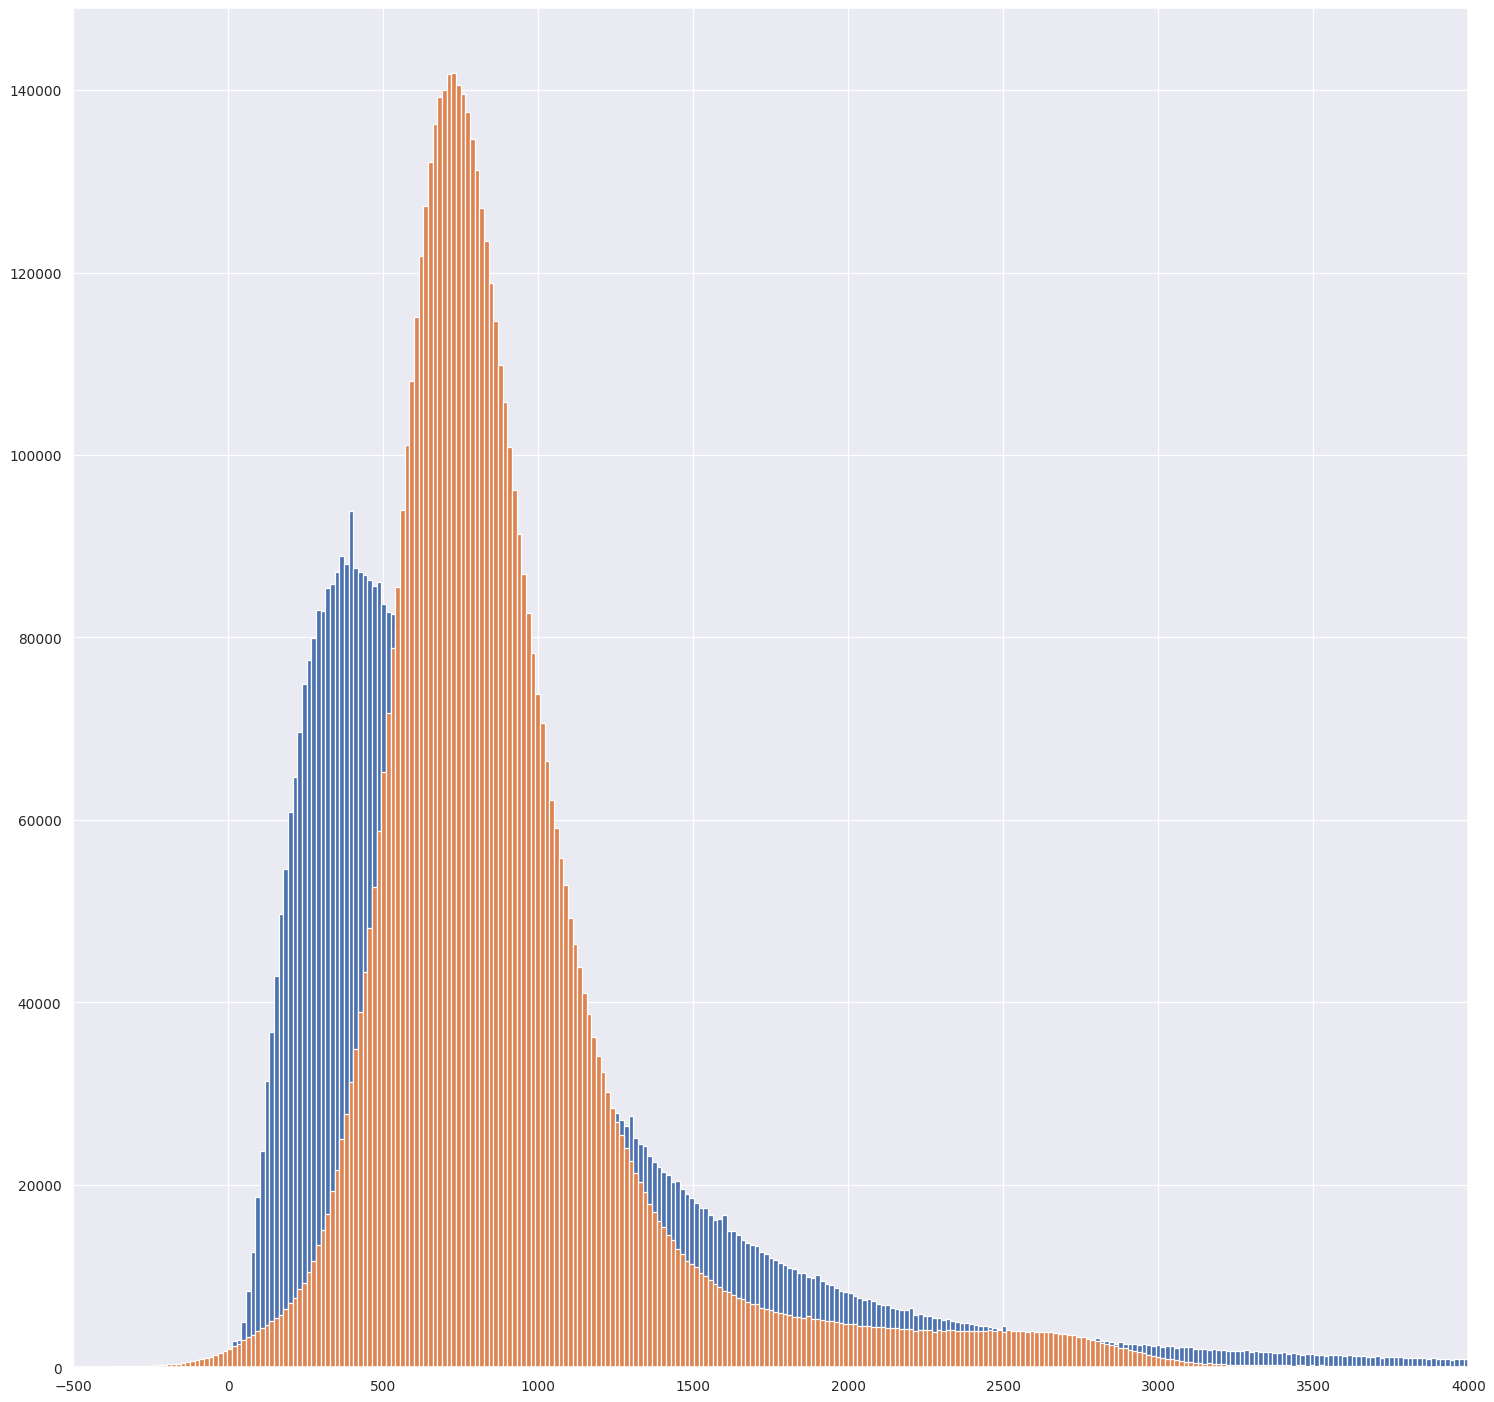

In [68]:
plt.figure(figsize=(20, 20))
plt.hist(tr_ans, bins=np.linspace(-500, 4000, 300))
plt.hist(predicted, bins=np.linspace(-500, 4000, 300))
plt.xlim(-500, 4000)
pass

Посмотрим на MSE:
$$
MSE = \dfrac{1}{N}\sum\limits_{i = 1}^{n} (y_i - \hat{y}_i)^2
$$

In [70]:
mean_squared_error(tr_ans, predicted)

132653.0653353877

Видим довольно большое значение. Будем использовать его как отправную точку для оценки качества последующих моделей, т.к. тут мы знаем, что это не очень хороший результат.

Посмотрим, как наша модель предскажет значения для тестовой выборки:

In [71]:
predicted = reg19_wp.predict(test)

Построим аналогичные оценки.

(-2000.0, 2000.0)

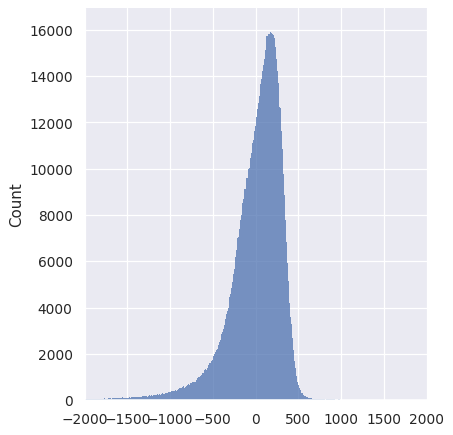

In [74]:
sns.displot(predicted - ts_ans)
plt.xlim(-2000, 2000)

In [75]:
np.mean(np.abs(predicted - ts_ans))

237.35668651673902

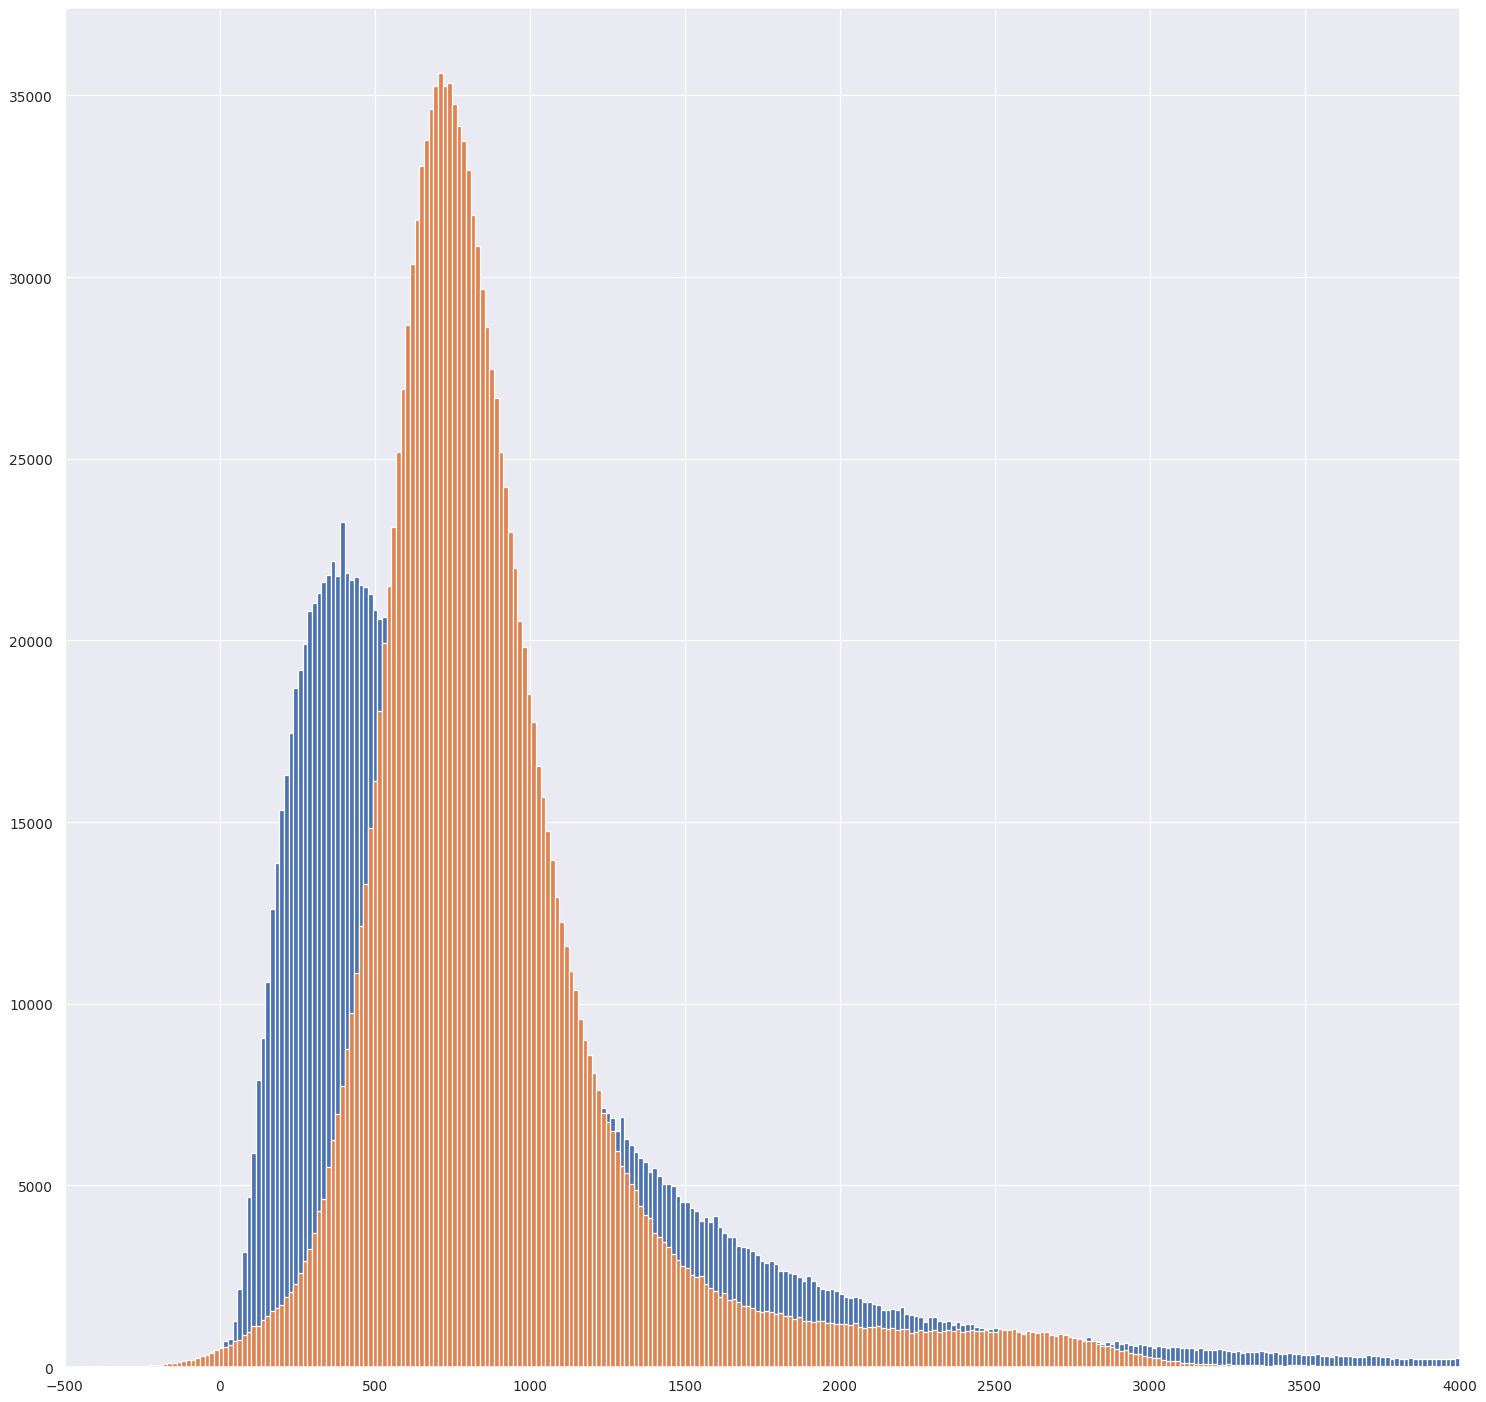

In [76]:
plt.figure(figsize=(20, 20))
plt.hist(ts_ans, bins=np.linspace(-500, 4000, 300))
plt.hist(predicted, bins=np.linspace(-500, 4000, 300))
plt.xlim(-500, 4000)
pass

In [78]:
mean_squared_error(ts_ans, predicted)

129061.36977787042

Ситуация почти полностью аналогичная. С точностью до погрешности.

# Посмотреть на коэффициенты фичей, мб что-то выкинуть. Пообучать регрессию с параметрами.